In [22]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from konlpy.tag import Mecab
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 데이터 가져오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')  # 하나라도 Nan있으면 삭제
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()  
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 앞에 4개
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

   
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# index_to_word
index_to_word = {index:word for word, index in word_to_index.items()}

In [24]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [25]:
# 모델 분석 및 가공
# 데이터셋 내 문장 길이 분포
total_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in total_data]  # len([32, 74, 919, 4, 4, 39, 228, 20, 33, 748)]들을 리스트로 
num_tokens = np.array(num_tokens)

print("평균:",np.mean(num_tokens))
print("최대길이:",np.max(num_tokens))
print("표준편차:",np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print("전체 문장 {}%가 maxlen설장 값 이내에 포함".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

# 적절한 최대 문장 길이 지정
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding="pre", maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding="pre", maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)


평균: 15.96940191154864
최대길이: 116
표준편차: 12.843571191092
전체 문장 0.9342988343341575%가 maxlen설장 값 이내에 포함
(146182, 41)
(49157, 41)


In [26]:
# validation set 
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

print(X_train.shape)
print(X_valid.shape)

(116945, 41)
(29237, 41)


In [27]:
# 모델 설계
vocab_size = len(word_to_index) # 어휘 사전 크기
word_vector_dim = 41 # 차원수

# [model-1] LSTM
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8)) 
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1600      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 모델 훈련
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

epochs = 20
history = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
229/229 [==============================] - 3s 8ms/step - loss: 0.5239 - accuracy: 0.7450 - val_loss: 0.3866 - val_accuracy: 0.8386
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3442 - accuracy: 0.8557 - val_loss: 0.3481 - val_accuracy: 0.8508
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3139 - accuracy: 0.8693 - val_loss: 0.3437 - val_accuracy: 0.8514
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2990 - accuracy: 0.8768 - val_loss: 0.3450 - val_accuracy: 0.8527
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2853 - accuracy: 0.8832 - val_loss: 0.3462 - val_accuracy: 0.8536
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2740 - accuracy: 0.8877 - val_loss: 0.3481 - val_accuracy: 0.8533
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2626 - accuracy: 0.8933 - val_loss: 0.3625 - val_accuracy: 0.8521
Epoch 

In [46]:
# 평가
result = model_lstm.evaluate(X_test,  y_test, verbose=2) 
print(result)

1537/1537 - 3s - loss: 0.5273 - accuracy: 0.8337
[0.5272906422615051, 0.8336554169654846]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


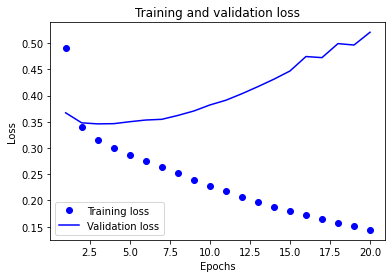

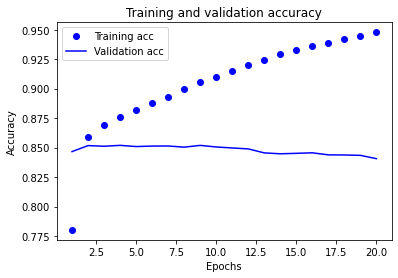

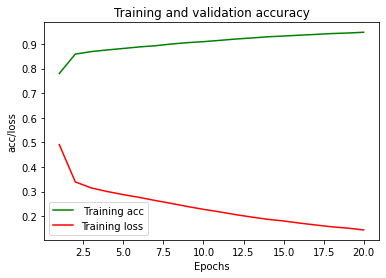

In [47]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

history_dict = history.history # accuracy, loss 가져온다.
print(history_dict.keys())

loss = history_dict["loss"]
accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# epoch-loss 그래프
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# epoch-accuracy 그래프
plt.clf()

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# epoch - acc/loss 그래프

plt.clf()

plt.plot(epochs, accuracy, 'g', label=' Training acc')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc/loss')
plt.legend()

plt.show()


In [48]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/workspace/ex6_word2vec_lstm.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("우정")

(10000, 41)


[('퀄리티', 0.8651092052459717),
 ('흥', 0.8621377944946289),
 ('하하하하하', 0.8593959212303162),
 ('향기', 0.8260975480079651),
 ('참신', 0.822695791721344),
 ('볼', 0.8183740973472595),
 ('기적', 0.8180095553398132),
 ('출', 0.8159787654876709),
 ('즐거운', 0.8128039836883545),
 ('올인', 0.804060161113739)]

In [49]:
# [model-2] 1-D CNN

model_1dcnn = tf.keras.Sequential()
model_1dcnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1dcnn.add(tf.keras.layers.MaxPooling1D(5))
model_1dcnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1dcnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dcnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_1dcnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_1dcnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          4608      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [50]:
# 모델 훈련
model_1dcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

epochs = 20
history = model_1dcnn.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.4617 - accuracy: 0.7778 - val_loss: 0.3545 - val_accuracy: 0.8435
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3144 - accuracy: 0.8662 - val_loss: 0.3370 - val_accuracy: 0.8537
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2700 - accuracy: 0.8900 - val_loss: 0.3343 - val_accuracy: 0.8563
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.2222 - accuracy: 0.9143 - val_loss: 0.3580 - val_accuracy: 0.8520
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1709 - accuracy: 0.9374 - val_loss: 0.3917 - val_accuracy: 0.8496
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.1227 - accuracy: 0.9585 - val_loss: 0.4487 - val_accuracy: 0.8406
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.0867 - accuracy: 0.9726 - val_loss: 0.5201 - val_accuracy: 0.8399
Epoch 

In [51]:
# 평가
result = model_1dcnn.evaluate(X_test,  y_test, verbose=2) 
print(result)

1537/1537 - 3s - loss: 1.1437 - accuracy: 0.8194
[1.1437321901321411, 0.8194153308868408]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


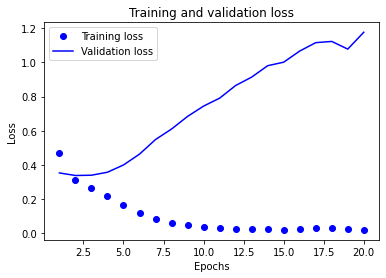

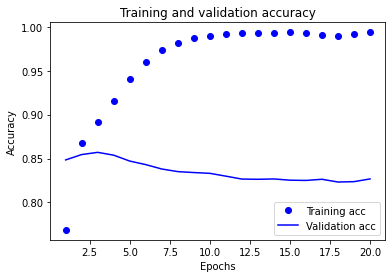

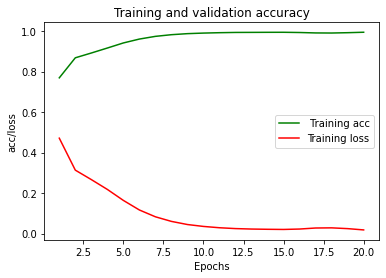

In [14]:
# Loss, Accuracy 그래프 시각화
history_dict = history.history # accuracy, loss 가져온다.
print(history_dict.keys())

loss = history_dict["loss"]
accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# epoch-loss 그래프
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# epoch-accuracy 그래프
plt.clf()

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# epoch - acc/loss 그래프

plt.clf()

plt.plot(epochs, accuracy, 'g', label=' Training acc')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc/loss')
plt.legend()

plt.show()


In [52]:
embedding_layer = model_1dcnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/workspace/ex6_word2vec_cnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록 
vectors = model_1dcnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("우정")

(10000, 41)


[('갖추', 0.6386409997940063),
 ('브', 0.6321302652359009),
 ('김남길', 0.6264898777008057),
 ('마다', 0.6162876486778259),
 ('다물', 0.5990211367607117),
 ('명장면', 0.5922313332557678),
 ('묘한', 0.5915171504020691),
 ('국내', 0.5678679347038269),
 ('발생', 0.5632069110870361),
 ('포스트', 0.5559356808662415)]

In [53]:
# [model-3] GlobalMaxPooling1D만 사용
model_mp = tf.keras.Sequential()
model_mp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_mp.add(tf.keras.layers.GlobalMaxPooling1D())
model_mp.add(tf.keras.layers.Dense(8, activation='relu'))
model_mp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_mp.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 41)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 336       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [54]:
# 모델 훈련
model_mp.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

epochs = 20
history = model_mp.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
229/229 [==============================] - 1s 4ms/step - loss: 0.5269 - accuracy: 0.7799 - val_loss: 0.3808 - val_accuracy: 0.8352
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3416 - accuracy: 0.8540 - val_loss: 0.3484 - val_accuracy: 0.8488
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2977 - accuracy: 0.8758 - val_loss: 0.3442 - val_accuracy: 0.8508
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2677 - accuracy: 0.8911 - val_loss: 0.3495 - val_accuracy: 0.8507
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2421 - accuracy: 0.9044 - val_loss: 0.3597 - val_accuracy: 0.8478
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2189 - accuracy: 0.9145 - val_loss: 0.3736 - val_accuracy: 0.8452
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.1976 - accuracy: 0.9249 - val_loss: 0.3914 - val_accuracy: 0.8428
Epoch 

In [55]:
# 평가
result_mp = model_mp.evaluate(X_test,  y_test, verbose=2) 
print(result_mp)

1537/1537 - 2s - loss: 0.7809 - accuracy: 0.8173
[0.7809270620346069, 0.8172590136528015]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


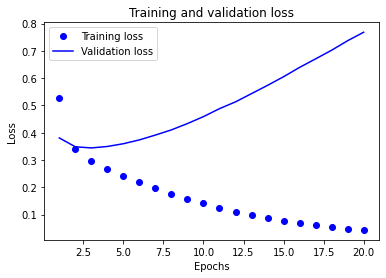

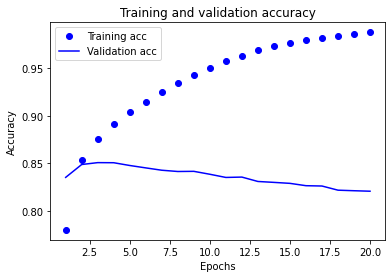

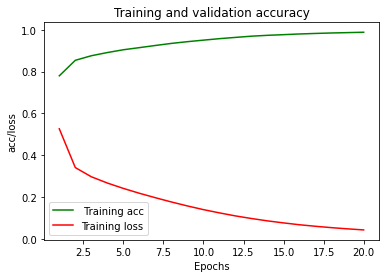

In [56]:
# Loss, Accuracy 그래프 시각화
history_dict = history.history # accuracy, loss 가져온다.
print(history_dict.keys())

loss = history_dict["loss"]
accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# epoch-loss 그래프
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# epoch-accuracy 그래프
plt.clf()

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# epoch - acc/loss 그래프

plt.clf()

plt.plot(epochs, accuracy, 'g', label=' Training acc')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc/loss')
plt.legend()

plt.show()


In [58]:
embedding_layer = model_mp.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/workspace/ex6_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

# 단어 개수(에서 특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록 
vectors = model_mp.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("우정")

(10000, 41)


[('지성', 0.6544758081436157),
 ('제레미', 0.6258237361907959),
 ('릴리', 0.5919701457023621),
 ('맴돈', 0.5900551676750183),
 ('우린', 0.5892146825790405),
 ('블리', 0.5860978364944458),
 ('드러낸', 0.5799271464347839),
 ('테러리스트', 0.5692098140716553),
 ('부성애', 0.5590226650238037),
 ('본질', 0.55584317445755)]

회고
헷갈리는 부분이 있어 다시 공부가 필요할것 같고 전처리가 중요할것 같다.